In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from Bio import pairwise2
from Bio import Seq
import math
import json
import networkx as nx
from scipy.stats import ttest_ind

#### Substitution analysis relative to TCR-antigen binding affinity:

Modified the original hash implementation to:
- return all the sequences matching
- allow for pairwise alignment within the same set (and avoid the same sequence being aligned to itself)

In [2]:
def _pairwise2_list(list_compare, seq, min_score):
    matching_sequences = []
    for compare_seq in list_compare:
        current_score = pairwise2.align.globalxs(compare_seq, seq, -1, -1, score_only=True)
        if current_score >= min_score:
            matching_sequences.append((current_score, compare_seq))
    return matching_sequences

class HashedAln:
    def __init__(self, ref_clones, clone_ids, kmer_size, num_errors):
        self.reference_clones = {k:v for k,v in zip(clone_ids, ref_clones)}
        self._reference_clones_seq = ref_clones
        self.kmer_size = kmer_size
        self.num_errors = num_errors
    
    def build_index(self):
        self.index = {}
        for clone_id, seq in self.reference_clones.items():
            kmers = [seq[i:(i + self.kmer_size)] for i in range(0,len(seq), self.kmer_size)]
            for km in kmers:
                if km in self.index:
                    self.index[km].append(clone_id)
                else:
                    self.index[km]=[clone_id]
    
    def _align_clones_hash(self, query_clones, query_clone_ids):
        aligned_clones = []
        unaligned_clones = []
        for query_clone_id, clone in zip(query_clone_ids, query_clones):
            hits = set()
            kmers = [clone[i:(i + self.kmer_size)] for i in range(0,len(clone), self.kmer_size)]
            for km in kmers:
                if km in self.index:
                    hits.update(self.index[km])
            hits = [hit for hit in hits if hit != query_clone_id]
            if len(hits) > 0:
                hits_seq = [self.reference_clones[k] for k in hits]
                min_score = len(clone) - self.num_errors
                aligned_clones.append(_pairwise2_list(hits_seq, clone, min_score))
            else:
                aligned_clones.append([])
        return aligned_clones
    
    def _align_clones_pairwise(self, query_clones):
        aligned_clones = [ _pairwise2_list(self._reference_clones_seq, clone, len(clone) - self.num_errors)
            for clone in query_clones ]
        return aligned_clones
    
    def align_clones(self, query_clones, query_clone_ids):
        print("Aligning with hash")
        aligned = self._align_clones_hash(query_clones, query_clone_ids)
        print("Done")
        return aligned

In [4]:
df_vdjdb = pd.read_csv("data/vdjdb/SearchTable-2022-01-21 09_44_36.727.tsv", sep="\t")

In [5]:
df_vdjdb

,complex.id,Gene,CDR3,V,J,Species,MHC A,MHC B,MHC class,Epitope,Epitope gene,Epitope species,Reference,Method,Meta,CDR3fix,Score
0,1,TRB,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,Nef,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CASSYLPGQGDHYSNQPQHF"", ""cdr3_old"": ""...",2
1,0,TRB,CASSFEAGQGFFSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,Nef,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CASSFEAGQGFFSNQPQHF"", ""cdr3_old"": ""C...",2
2,2,TRB,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,Nef,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CASSFEPGQGFYSNQPQHF"", ""cdr3_old"": ""C...",2
3,3,TRB,CASSYEPGQVSHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,Nef,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CASSYEPGQVSHYSNQPQHF"", ""cdr3_old"": ""...",2
4,4,TRB,CASSALASLNEQFF,TRBV14*01,TRBJ2-1*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,Nef,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CASSALASLNEQFF"", ""cdr3_old"": ""CASSAL...",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73428,26172,TRA,CAFLNAGGTSYGKLTF,TRAV38-1*01,TRAJ52*01,HomoSapiens,HLA-A*24:01,B2M,MHCI,QYIKWPWYI,Spike,SARS-CoV-2,PMID:34086357,"{""frequency"": ""1/11"", ""identification"": ""tetra...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CAFLNAGGTSYGKLTF"", ""cdr3_old"": ""CAFL...",1
73429,26173,TRA,CAVYNQGGKLIF,TRAV8-1*01,TRAJ23*01,HomoSapiens,HLA-A*24:01,B2M,MHCI,QYIKWPWYI,Spike,SARS-CoV-2,PMID:34086357,"{""frequency"": ""1/11"", ""identification"": ""tetra...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CAVYNQGGKLIF"", ""cdr3_old"": ""CAVYNQGG...",1
73430,26174,TRA,CAVRALYNFNKFYF,TRAV3*01,TRAJ21*01,HomoSapiens,HLA-A*24:01,B2M,MHCI,QYIKWPWYI,Spike,SARS-CoV-2,PMID:34086357,"{""frequency"": ""1/11"", ""identification"": ""tetra...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CAVRALYNFNKFYF"", ""cdr3_old"": ""CAVRAL...",1
73431,26175,TRA,CAVESYNTDKLIF,TRAV41*01,TRAJ34*01,HomoSapiens,HLA-A*24:01,B2M,MHCI,QYIKWPWYI,Spike,SARS-CoV-2,PMID:34086357,"{""frequency"": ""1/11"", ""identification"": ""tetra...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CAVESYNTDKLIF"", ""cdr3_old"": ""CAVESYN...",1


In [6]:
df_vdjdb_len = df_vdjdb.drop_duplicates(subset="CDR3").loc[:, ["CDR3"]]

In [7]:
df_vdjdb_len["length"] = df_vdjdb_len.apply(lambda x: len(x["CDR3"]), axis=1)

array([[<AxesSubplot:title={'center':'length'}>]], dtype=object)

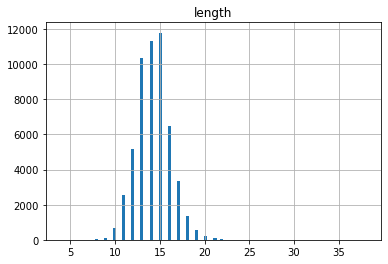

In [8]:
df_vdjdb_len.hist("length", bins=100)

In [9]:
len(df_vdjdb_len)

54181

Choose only amino acids with length > 12 (easier to compute, use kmer of 6):

In [10]:
df_vdjdb_len = df_vdjdb_len.loc[df_vdjdb_len["length"] >= 12,:]
df_vdjdb_len = df_vdjdb_len.reset_index(drop=True)
df_vdjdb_len["id"] = df_vdjdb_len.index

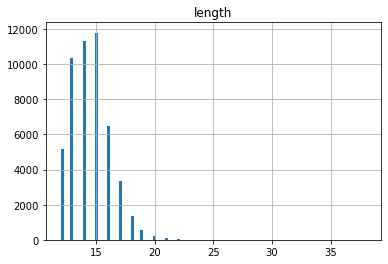

In [11]:
df_vdjdb_len.hist("length", bins=100)
plt.show()

In [12]:
len(df_vdjdb_len)

50726

In [13]:
aligner_vdjdb = HashedAln(df_vdjdb_len["CDR3"].to_list(), df_vdjdb_len["id"].to_list(), 6, 1)
aligner_vdjdb.build_index()

In [13]:
vdjdb_alignments = aligner_vdjdb.align_clones(df_vdjdb_len["CDR3"].to_list(), df_vdjdb_len["id"].to_list())

Aligning with hash
Done


In [16]:
df_vdjdb_results = pd.DataFrame({"CDR3": df_vdjdb_len["CDR3"].to_list(), "cdr3_alignments": vdjdb_alignments})

In [17]:
df_vdjdb_results

,CDR3,cdr3_alignments
0,CASSYLPGQGDHYSNQPQHF,[]
1,CASSFEAGQGFFSNQPQHF,[]
2,CASSFEPGQGFYSNQPQHF,[]
3,CASSYEPGQVSHYSNQPQHF,[]
4,CASSALASLNEQFF,[]
...,...,...
50721,CAVRHTNAGKSTF,"[(12.0, CAVRDTNAGKSTF)]"
50722,CAFLNAGGTSYGKLTF,"[(15.0, CAFFNAGGTSYGKLTF), (15.0, CAPLNAGGTSYG..."
50723,CAVRALYNFNKFYF,"[(13.0, CAVRGLYNFNKFYF)]"
50724,CAVESYNTDKLIF,"[(12.0, CAVGSYNTDKLIF), (12.0, CAVSSYNTDKLIF),..."


In [ ]:
df_vdjdb_results = df_vdjdb_results.explode('cdr3_alignments').reset_index(drop=True)

In [19]:
df_vdjdb_results = df_vdjdb_results.dropna()
df_vdjdb_results["cdr3_alignments"] = df_vdjdb_results["cdr3_alignments"].apply(lambda x: x[1])
df_vdjdb_results

,CDR3,cdr3_alignments
5,CASSFGVEDEQYF,CASNFGVEDEQYF
6,CASSFGVEDEQYF,CASSLGVEDEQYF
7,CASSIRSTDTQYF,CASSVRSTDTQYF
8,CASSIRSTDTQYF,CASSPRSTDTQYF
9,CASSIRSTDTQYF,CASSTRSTDTQYF
...,...,...
90512,CAVESYNTDKLIF,CAVASYNTDKLIF
90513,CAVESYNTDKLIF,CAVISYNTDKLIF
90514,CAVESYNTDKLIF,CAVPSYNTDKLIF
90515,CAMREGQGNAGNMLTF,CAMREGIGNAGNMLTF


In [49]:
df_vdjdb_results.to_csv("data/vdjdb/vdjdb_cdr3_alignments_all.csv", index=False)

The alignment of all the sequences in the VDJdb database can take a long time (2hr +), so to save time you can simply load the results:

In [48]:
df_vdjdb_results = pd.read_csv("data/vdjdb/vdjdb_cdr3_alignments_all.csv")

Remove all duplicates, so that each pair of CDR3 sequence is only represented once:

In [16]:
df_vdjdb_noduplicates = pd.DataFrame(np.sort(df_vdjdb_results[["CDR3", "cdr3_alignments"]],1),
                                    index=df_vdjdb_results.index, 
                                    columns=["cdr3_1", "cdr3_2"]).drop_duplicates()

In [17]:
df_vdjdb_noduplicates

,cdr3_1,cdr3_2
0,CASNFGVEDEQYF,CASSFGVEDEQYF
1,CASSFGVEDEQYF,CASSLGVEDEQYF
2,CASSIRSTDTQYF,CASSVRSTDTQYF
3,CASSIRSTDTQYF,CASSPRSTDTQYF
4,CASSIRSTDTQYF,CASSTRSTDTQYF
...,...,...
57532,CAANTEGADRLTF,CAAYTEGADRLTF
57534,CAVSMDYSNNRLTLF,CAVSTDYSNNRLTLF
57539,CAASEGSNYNVLYF,CAASMGSNYNVLYF
57585,CAVNDYGQNFVF,CAVSDYGQNFVF


In [18]:
df_vdjdb_noduplicates = df_vdjdb_noduplicates.loc[df_vdjdb_noduplicates["cdr3_1"].str.len() == df_vdjdb_noduplicates["cdr3_2"].str.len(), :]

Get the substituted amino acid:

In [19]:
def get_changed_aa(row):
    error = []
    cdr3_1 = row["cdr3_1"]
    cdr3_2 = row["cdr3_2"]
    for i in range(len(cdr3_1)):
        if cdr3_1[i] != cdr3_2[i]:
            error = [cdr3_1[i], cdr3_2[i]]
            break
    return error

In [20]:
df_vdjdb_noduplicates.loc[:, "change"] = df_vdjdb_noduplicates.apply(get_changed_aa, axis=1)

/var/folders/ww/wp54dp116f919zl6ld381gmr0000gn/T/ipykernel_27423/2184953752.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vdjdb_noduplicates.loc[:, "change"] = df_vdjdb_noduplicates.apply(get_changed_aa, axis=1)


In [21]:
df_vdjdb_noduplicates

,cdr3_1,cdr3_2,change
0,CASNFGVEDEQYF,CASSFGVEDEQYF,"[N, S]"
1,CASSFGVEDEQYF,CASSLGVEDEQYF,"[F, L]"
2,CASSIRSTDTQYF,CASSVRSTDTQYF,"[I, V]"
3,CASSIRSTDTQYF,CASSPRSTDTQYF,"[I, P]"
4,CASSIRSTDTQYF,CASSTRSTDTQYF,"[I, T]"
...,...,...,...
57532,CAANTEGADRLTF,CAAYTEGADRLTF,"[N, Y]"
57534,CAVSMDYSNNRLTLF,CAVSTDYSNNRLTLF,"[M, T]"
57539,CAASEGSNYNVLYF,CAASMGSNYNVLYF,"[E, M]"
57585,CAVNDYGQNFVF,CAVSDYGQNFVF,"[N, S]"


In [23]:
df_blosum_matrix = pd.read_csv("data/BLOSUM62.csv")
df_blosum_matrix

,A,R,N,D,C,Q,E,G,H,I,...,P,S,T,W,Y,V,B,Z,X,*
A,4,-1,-2,-2,0,-1,-1,0,-2,-1,...,-1,1,0,-3,-2,0,-2,-1,0,-4
R,-1,5,0,-2,-3,1,0,-2,0,-3,...,-2,-1,-1,-3,-2,-3,-1,0,-1,-4
N,-2,0,6,1,-3,0,0,0,1,-3,...,-2,1,0,-4,-2,-3,3,0,-1,-4
D,-2,-2,1,6,-3,0,2,-1,-1,-3,...,-1,0,-1,-4,-3,-3,4,1,-1,-4
C,0,-3,-3,-3,9,-3,-4,-3,-3,-1,...,-3,-1,-1,-2,-2,-1,-3,-3,-2,-4
Q,-1,1,0,0,-3,5,2,-2,0,-3,...,-1,0,-1,-2,-1,-2,0,3,-1,-4
E,-1,0,0,2,-4,2,5,-2,0,-3,...,-1,0,-1,-3,-2,-2,1,4,-1,-4
G,0,-2,0,-1,-3,-2,-2,6,-2,-4,...,-2,0,-2,-2,-3,-3,-1,-2,-1,-4
H,-2,0,1,-1,-3,0,0,-2,8,-3,...,-2,-1,-2,-2,2,-3,0,0,-1,-4
I,-1,-3,-3,-3,-1,-3,-3,-4,-3,4,...,-3,-2,-1,-3,-1,3,-3,-3,-1,-4


In [24]:
df_grantham_matrix = pd.read_csv("data/grantham.matrix.txt", sep="\t")
df_grantham_matrix.rename(columns={". A": "A"})

,A,R,N,D,C,Q,E,G,H,I,L,K,M,F,P,S,T,W,Y,V
A,0,112,111,126,195,91,107,60,86,94,96,106,84,113,27,99,58,148,112,64
R,112,0,86,96,180,43,54,125,29,97,102,26,91,97,103,110,71,101,77,96
N,111,86,0,23,139,46,42,80,68,149,153,94,142,158,91,46,65,174,143,133
D,126,96,23,0,154,61,45,94,81,168,172,101,160,177,108,65,85,181,160,152
C,195,180,139,154,0,154,170,159,174,198,198,202,196,205,169,112,149,215,194,192
Q,91,43,46,61,154,0,29,87,24,109,113,53,101,116,76,68,42,130,99,96
E,107,54,42,45,170,29,0,98,40,134,138,56,126,140,93,80,65,152,122,121
G,60,125,80,94,159,87,98,0,98,135,138,127,127,153,42,56,59,184,147,109
H,86,29,68,81,174,24,40,98,0,94,99,32,87,100,77,89,47,115,83,84
I,94,97,149,168,198,109,134,135,94,0,5,102,10,21,95,142,89,61,33,29


Add antigen information:

In [22]:
df_vdjdb_antigens = df_vdjdb.drop_duplicates(subset=["CDR3", "Epitope"]).loc[:, ["CDR3", "Epitope"]]
df_vdjdb_antigens

,CDR3,Epitope
0,CASSYLPGQGDHYSNQPQHF,FLKEKGGL
1,CASSFEAGQGFFSNQPQHF,FLKEKGGL
2,CASSFEPGQGFYSNQPQHF,FLKEKGGL
3,CASSYEPGQVSHYSNQPQHF,FLKEKGGL
4,CASSALASLNEQFF,FLKEKGGL
...,...,...
73428,CAFLNAGGTSYGKLTF,QYIKWPWYI
73429,CAVYNQGGKLIF,QYIKWPWYI
73430,CAVRALYNFNKFYF,QYIKWPWYI
73431,CAVESYNTDKLIF,QYIKWPWYI


In [26]:
df_vdjdb_noduplicates_antigen = df_vdjdb_noduplicates.merge(df_vdjdb_antigens, how="left", left_on="cdr3_1", right_on="CDR3")
df_vdjdb_noduplicates_antigen = df_vdjdb_noduplicates_antigen.drop(columns="CDR3")
df_vdjdb_noduplicates_antigen = df_vdjdb_noduplicates_antigen.rename(columns={"Epitope": "epitope_1"})
df_vdjdb_noduplicates_antigen = df_vdjdb_noduplicates_antigen.merge(df_vdjdb_antigens, how="left", left_on="cdr3_2", right_on="CDR3")
df_vdjdb_noduplicates_antigen = df_vdjdb_noduplicates_antigen.drop(columns="CDR3")
df_vdjdb_noduplicates_antigen = df_vdjdb_noduplicates_antigen.rename(columns={"Epitope": "epitope_2"})

In [27]:
df_vdjdb_noduplicates_antigen

,cdr3_1,cdr3_2,change,epitope_1,epitope_2
0,CASNFGVEDEQYF,CASSFGVEDEQYF,"[N, S]",LQPFPQPELPYPQPQ,LQPFPQPELPYPQPQ
1,CASSFGVEDEQYF,CASSLGVEDEQYF,"[F, L]",LQPFPQPELPYPQPQ,LQPFPQPELPYPQPQ
2,CASSIRSTDTQYF,CASSVRSTDTQYF,"[I, V]",LQPFPQPELPYPQPQ,APQPELPYPQPG
3,CASSIRSTDTQYF,CASSVRSTDTQYF,"[I, V]",LQPFPQPELPYPQPQ,GILGFVFTL
4,CASSIRSTDTQYF,CASSVRSTDTQYF,"[I, V]",GILGFVFTL,APQPELPYPQPG
...,...,...,...,...,...
43257,CAANTEGADRLTF,CAAYTEGADRLTF,"[N, Y]",KAVYNFATC,KAVYNFATC
43258,CAVSMDYSNNRLTLF,CAVSTDYSNNRLTLF,"[M, T]",KAVYNFATC,KAVYNFATC
43259,CAASEGSNYNVLYF,CAASMGSNYNVLYF,"[E, M]",KAVYNFATC,KAVYNFATC
43260,CAVNDYGQNFVF,CAVSDYGQNFVF,"[N, S]",QIKVRVDMV,QIKVRVDMV


Get substitution score for each match:

In [28]:
def get_substitution_score(row):
    return df_grantham_matrix.loc[row["change"][0], row["change"][1]]

Perform analysis for clones binding to the same antigen:

In [29]:
df_vdjdb_noduplicates_sameantigen = df_vdjdb_noduplicates_antigen.loc[df_vdjdb_noduplicates_antigen["epitope_1"] == df_vdjdb_noduplicates_antigen["epitope_2"], :]
df_vdjdb_noduplicates_sameantigen["substitution_score"] = df_vdjdb_noduplicates_sameantigen.apply(get_substitution_score, axis=1)

/var/folders/ww/wp54dp116f919zl6ld381gmr0000gn/T/ipykernel_27423/204865549.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vdjdb_noduplicates_sameantigen["substitution_score"] = df_vdjdb_noduplicates_sameantigen.apply(get_substitution_score, axis=1)


In [35]:
df_vdjdb_noduplicates_sameantigen

,cdr3_1,cdr3_2,change,epitope_1,epitope_2,substitution_score
0,CASNFGVEDEQYF,CASSFGVEDEQYF,"[N, S]",LQPFPQPELPYPQPQ,LQPFPQPELPYPQPQ,46
1,CASSFGVEDEQYF,CASSLGVEDEQYF,"[F, L]",LQPFPQPELPYPQPQ,LQPFPQPELPYPQPQ,22
5,CASSIRSTDTQYF,CASSVRSTDTQYF,"[I, V]",GILGFVFTL,GILGFVFTL,29
8,CASSIRSTDTQYF,CASSPRSTDTQYF,"[I, P]",GILGFVFTL,GILGFVFTL,95
11,CASSIRSTDTQYF,CASSTRSTDTQYF,"[I, T]",GILGFVFTL,GILGFVFTL,89
...,...,...,...,...,...,...
43257,CAANTEGADRLTF,CAAYTEGADRLTF,"[N, Y]",KAVYNFATC,KAVYNFATC,143
43258,CAVSMDYSNNRLTLF,CAVSTDYSNNRLTLF,"[M, T]",KAVYNFATC,KAVYNFATC,81
43259,CAASEGSNYNVLYF,CAASMGSNYNVLYF,"[E, M]",KAVYNFATC,KAVYNFATC,126
43260,CAVNDYGQNFVF,CAVSDYGQNFVF,"[N, S]",QIKVRVDMV,QIKVRVDMV,46


In [30]:
print(df_vdjdb_noduplicates_sameantigen["substitution_score"].mean())
print(df_vdjdb_noduplicates_sameantigen["substitution_score"].sem())
print(df_vdjdb_noduplicates_sameantigen["substitution_score"].std())

85.67496573777981
0.29507569348740786
39.04822622735189


Perform analysis for clones binding to the different antigens:

In [32]:
df_vdjdb_noduplicates_diffantigen = df_vdjdb_noduplicates_antigen.loc[df_vdjdb_noduplicates_antigen["epitope_1"] != df_vdjdb_noduplicates_antigen["epitope_2"], :]
df_vdjdb_noduplicates_diffantigen["substitution_score"] = df_vdjdb_noduplicates_diffantigen.apply(get_substitution_score, axis=1)

/var/folders/ww/wp54dp116f919zl6ld381gmr0000gn/T/ipykernel_27423/344385145.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vdjdb_noduplicates_diffantigen["substitution_score"] = df_vdjdb_noduplicates_diffantigen.apply(get_substitution_score, axis=1)


In [34]:
df_vdjdb_noduplicates_diffantigen

,cdr3_1,cdr3_2,change,epitope_1,epitope_2,substitution_score
2,CASSIRSTDTQYF,CASSVRSTDTQYF,"[I, V]",LQPFPQPELPYPQPQ,APQPELPYPQPG,29
3,CASSIRSTDTQYF,CASSVRSTDTQYF,"[I, V]",LQPFPQPELPYPQPQ,GILGFVFTL,29
4,CASSIRSTDTQYF,CASSVRSTDTQYF,"[I, V]",GILGFVFTL,APQPELPYPQPG,29
6,CASSIRSTDTQYF,CASSPRSTDTQYF,"[I, P]",LQPFPQPELPYPQPQ,GILGFVFTL,95
7,CASSIRSTDTQYF,CASSPRSTDTQYF,"[I, P]",LQPFPQPELPYPQPQ,AVFDRKSDAK,95
...,...,...,...,...,...,...
43245,CAMRGRTGNQFYF,CAMRGSTGNQFYF,"[R, S]",ALSKGVHFV,NYNYLYRLF,110
43246,CALTNAGGTSYGKLTF,CAPTNAGGTSYGKLTF,"[L, P]",LTDEMIAQY,VYIGDPAQL,98
43247,CAADNAGNMLTF,CAIDNAGNMLTF,"[A, I]",DTDFVNEFY,LLWNGPMAV,94
43248,CAANSGNTPLVF,CAARSGNTPLVF,"[N, R]",RYGSFSVTL,QYIKWPWYI,86


In [33]:
print(df_vdjdb_noduplicates_diffantigen["substitution_score"].mean())
print(df_vdjdb_noduplicates_diffantigen["substitution_score"].sem())

88.19530097087379
0.24555839910148886


Perform analysis for clones binding to the different antigens, and with no exact match between sets of aligned clones binding to different antigens:

In [36]:
df_antigenpairs = pd.DataFrame(np.sort(df_vdjdb_noduplicates_antigen[["epitope_1", "epitope_2"]],1),
                                    index=df_vdjdb_noduplicates_antigen.index, 
                                    columns=["epitope_1", "epitope_2"]).drop_duplicates()
df_antigenpairs = df_antigenpairs.loc[df_antigenpairs["epitope_1"] != df_antigenpairs["epitope_2"],:]

In [37]:
df_antigenpairs

,epitope_1,epitope_2
2,APQPELPYPQPG,LQPFPQPELPYPQPQ
3,GILGFVFTL,LQPFPQPELPYPQPQ
4,APQPELPYPQPG,GILGFVFTL
7,AVFDRKSDAK,LQPFPQPELPYPQPQ
9,AVFDRKSDAK,GILGFVFTL
...,...,...
43245,ALSKGVHFV,NYNYLYRLF
43246,LTDEMIAQY,VYIGDPAQL
43247,DTDFVNEFY,LLWNGPMAV
43248,QYIKWPWYI,RYGSFSVTL


In [38]:
df_vdjdb_noduplicates_diffantigen_nooverlap = pd.DataFrame({"cdr3_1": [], "cdr3_2": [],
                                                            "change": [], "epitope_1": [], "epitope_2": []})

for _, row in df_antigenpairs.iterrows():
    df_antigen1 = pd.concat([df_vdjdb_noduplicates_antigen.loc[df_vdjdb_noduplicates_antigen["epitope_1"] == row["epitope_1"],["cdr3_1"]].rename(columns={"cdr3_1": "cdr3"}),
                                                        df_vdjdb_noduplicates_antigen.loc[df_vdjdb_noduplicates_antigen["epitope_2"] == row["epitope_1"],["cdr3_2"]].rename(columns={"cdr3_2": "cdr3"})])
    df_antigen2 = pd.concat([df_vdjdb_noduplicates_antigen.loc[df_vdjdb_noduplicates_antigen["epitope_1"] == row["epitope_2"],["cdr3_1"]].rename(columns={"cdr3_1": "cdr3"}),
                                                        df_vdjdb_noduplicates_antigen.loc[df_vdjdb_noduplicates_antigen["epitope_2"] == row["epitope_2"],["cdr3_2"]].rename(columns={"cdr3_2": "cdr3"})])
    if len(df_antigen1.merge(df_antigen2, how="inner")) == 0:
        df_vdjdb_noduplicates_paired_antigen = pd.concat([df_vdjdb_noduplicates_antigen.loc[(df_vdjdb_noduplicates_antigen["epitope_1"] == row["epitope_1"]) & (df_vdjdb_noduplicates_antigen["epitope_2"] == row["epitope_2"]),:],
                                                        df_vdjdb_noduplicates_antigen.loc[(df_vdjdb_noduplicates_antigen["epitope_1"] == row["epitope_2"]) & (df_vdjdb_noduplicates_antigen["epitope_2"] == row["epitope_1"]),:]])
        df_vdjdb_noduplicates_diffantigen_nooverlap = pd.concat([df_vdjdb_noduplicates_diffantigen_nooverlap, df_vdjdb_noduplicates_paired_antigen])

In [39]:
df_vdjdb_noduplicates_diffantigen_nooverlap["substitution_score"] = df_vdjdb_noduplicates_diffantigen_nooverlap.apply(get_substitution_score, axis=1)
print(df_vdjdb_noduplicates_diffantigen_nooverlap["substitution_score"].mean())
print(df_vdjdb_noduplicates_diffantigen_nooverlap["substitution_score"].sem())

88.87452741020795
0.5931683151335819


T-tests between 3 groups:

In [40]:
ttest_ind(df_vdjdb_noduplicates_sameantigen["substitution_score"], df_vdjdb_noduplicates_diffantigen_nooverlap["substitution_score"])

Ttest_indResult(statistic=-4.7946060352104665, pvalue=1.6407285987487036e-06)

In [41]:
ttest_ind(df_vdjdb_noduplicates_sameantigen["substitution_score"], df_vdjdb_noduplicates_diffantigen["substitution_score"])

Ttest_indResult(statistic=-6.55398113062932, pvalue=5.665104167654898e-11)

In [42]:
ttest_ind(df_vdjdb_noduplicates_diffantigen["substitution_score"], df_vdjdb_noduplicates_diffantigen_nooverlap["substitution_score"])

Ttest_indResult(statistic=-1.0422278998501497, pvalue=0.29731443502770866)

Plot results:

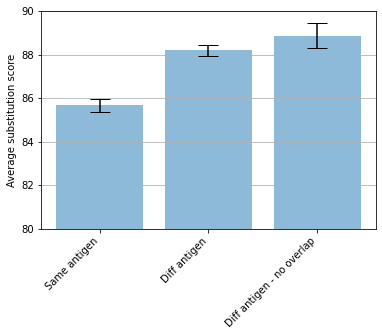

In [46]:
standard_errors = [df_vdjdb_noduplicates_sameantigen["substitution_score"].sem(),
                    df_vdjdb_noduplicates_diffantigen["substitution_score"].sem(),
                    df_vdjdb_noduplicates_diffantigen_nooverlap["substitution_score"].sem()]

means = [df_vdjdb_noduplicates_sameantigen["substitution_score"].mean(),
                    df_vdjdb_noduplicates_diffantigen["substitution_score"].mean(),
                    df_vdjdb_noduplicates_diffantigen_nooverlap["substitution_score"].mean()]
methods_x = [1, 2, 3]
methods = ["Same antigen", "Diff antigen", "Diff antigen - no overlap"]

fig, ax = plt.subplots()
ax.bar(methods_x, means, yerr=standard_errors, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Average substitution score')
ax.set_xticks(methods_x)
plt.xticks(rotation = 45, ha="right")
ax.set_xticklabels(methods)
plt.ylim(80, 90)
ax.yaxis.grid(True)
plt.savefig('substitution_score_cdr3.jpg', dpi=300, bbox_inches = "tight")
plt.show()

Analysis of VDJdb sequence confidence score (not included in paper): the goal here was to see whether the mismatches between aligned clones binding to the same antigen were potentially due to sequencing errors.   
  
The results were inconclusive, probably because the confidence score in the VDJdb database is not actually related to sequence quality.

In [98]:
df_vdjdb_score = df_vdjdb.drop_duplicates(subset=["CDR3", "Epitope", "Score"]).loc[:, ["CDR3", "Epitope", "Score"]]
df_vdjdb_score

,CDR3,Epitope,Score
0,CASSYLPGQGDHYSNQPQHF,FLKEKGGL,2
1,CASSFEAGQGFFSNQPQHF,FLKEKGGL,2
2,CASSFEPGQGFYSNQPQHF,FLKEKGGL,2
3,CASSYEPGQVSHYSNQPQHF,FLKEKGGL,2
4,CASSALASLNEQFF,FLKEKGGL,2
...,...,...,...
73428,CAFLNAGGTSYGKLTF,QYIKWPWYI,1
73429,CAVYNQGGKLIF,QYIKWPWYI,1
73430,CAVRALYNFNKFYF,QYIKWPWYI,1
73431,CAVESYNTDKLIF,QYIKWPWYI,1


In [106]:
df_score = pd.DataFrame(df_vdjdb_score.groupby(["CDR3", "Epitope"])["Score"].mean().reset_index())

In [107]:
df_score

,CDR3,Epitope,Score
0,CAAAAGNTGKLIF,HGIRNASFI,0.0
1,CAAAASGGSYIPTF,EPLPQGQLTAY,3.0
2,CAAAAYNQGGKLIF,KLGGALQAK,0.0
3,CAAADDKIIF,LLWNGPMAV,0.0
4,CAAADEEIGNQPQHF,ATDALMTGY,1.0
...,...,...,...
59210,CYSTWRLSCLLLCRDSAGAGSYQLTF,KLGGALQAK,0.0
59211,GDEAGTALIF,PKYVKQNTLKLAT,0.0
59212,LKENTGFQKLVF,GILGFVFTL,0.0
59213,SSGNQFYF,NLVPMVATV,3.0


In [110]:
df_vdjdb_noduplicates_sameantigen

,cdr3_1,cdr3_2,change,epitope_1,epitope_2,substitution_score
0,CASNFGVEDEQYF,CASSFGVEDEQYF,"[N, S]",LQPFPQPELPYPQPQ,LQPFPQPELPYPQPQ,1
1,CASSFGVEDEQYF,CASSLGVEDEQYF,"[F, L]",LQPFPQPELPYPQPQ,LQPFPQPELPYPQPQ,0
5,CASSIRSTDTQYF,CASSVRSTDTQYF,"[I, V]",GILGFVFTL,GILGFVFTL,3
8,CASSIRSTDTQYF,CASSPRSTDTQYF,"[I, P]",GILGFVFTL,GILGFVFTL,-3
11,CASSIRSTDTQYF,CASSTRSTDTQYF,"[I, T]",GILGFVFTL,GILGFVFTL,-1
...,...,...,...,...,...,...
43257,CAANTEGADRLTF,CAAYTEGADRLTF,"[N, Y]",KAVYNFATC,KAVYNFATC,-2
43258,CAVSMDYSNNRLTLF,CAVSTDYSNNRLTLF,"[M, T]",KAVYNFATC,KAVYNFATC,-1
43259,CAASEGSNYNVLYF,CAASMGSNYNVLYF,"[E, M]",KAVYNFATC,KAVYNFATC,-2
43260,CAVNDYGQNFVF,CAVSDYGQNFVF,"[N, S]",QIKVRVDMV,QIKVRVDMV,1


In [115]:
df_vdjdb_noduplicates_sameantigen["epitope_1"].value_counts()

KLGGALQAK         7046
GILGFVFTL         4008
SSYRRPVGI          701
TTPESANL           650
NLVPMVATV          488
                  ... 
YILKYSVFL            1
RFYKTLRAEQASQ        1
RLRPGGRKR            1
SGPLKAEIAQRLED       1
SPRWYFYYL            1
Name: epitope_1, Length: 132, dtype: int64

The hypothesis here is that one of the sequences of aligned clones binding to the same antigen is the correct one. Therefore for each connected component (in a graph of aligned clones), the sequence with the best score is the "true" sequence, and the other sequences should have a lower confidence score. In order to see if the average score of the other sequences was actually lower than expected, I simulated a random version, where the same number of N sequences as in the connected component were sampled randomly from the database, and the N-1 lower scores were averaged.

In [154]:
best_score_simulated = []
rest_score_simulated = []
best_score_sameantigen = []
rest_score_sameantigen = []

for epitope in df_vdjdb_noduplicates_sameantigen["epitope_1"].unique():
    graph_epitope = nx.from_pandas_edgelist(df_vdjdb_noduplicates_sameantigen[df_vdjdb_noduplicates_sameantigen['epitope_1'] == epitope], source='cdr3_1', target='cdr3_2')
    list_graphs = list(nx.connected_components(graph_epitope))
    for group in list_graphs:
        group = list(group)
        if len(group) > 1:
            subset_score = df_score.loc[(df_score["CDR3"].isin(group)) & (df_score["Epitope"] == epitope), :]
            subset_score = subset_score.sort_values(by=["Score"], ascending=False)
            best_score_sameantigen.append(subset_score.iloc[0,2])
            rest_score_sameantigen.append(subset_score.iloc[1:,2].mean())
            df_score = df_score.sample(frac=1)
            subset_score = df_score.iloc[:len(group), :]
            subset_score = subset_score.sort_values(by=["Score"], ascending=False)
            best_score_simulated.append(subset_score.iloc[0,2])
            rest_score_simulated.append(subset_score.iloc[1:,2].mean())

In [148]:
np.mean(np.array(rest_score_simulated))

0.015113727659519283

In [150]:
np.mean(np.array(best_score_simulated))

0.41883386771167314

In [149]:
np.mean(np.array(rest_score_sameantigen))

0.10295693482158016

In [151]:
np.mean(np.array(best_score_sameantigen))

0.30572378577366105